In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [12]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import matplotlib.pyplot as plt

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [16]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [17]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station


In [ ]:
conn = engine.connect()
cursor = conn.execute("Select * from sqlite_master where type = 'table'")
for c in cursor:
    print(c)


In [18]:
# Create our session (link) from Python to the DB
session=Session(engine)


# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#last date point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [20]:
# Calculate the date 1 year ago from the last date point in the database
previous_year=dt.date(2017,8,23)-dt.timedelta(days=365)
previous_year

datetime.date(2016, 8, 23)

In [21]:
# Perform a query to retrieve the date and precipitation scores
year_precip = session.query(measurement.date, measurement.prcp).\
        filter(measurement.date > previous_year).\
        order_by(measurement.date).all()
year_precip

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_data = pd.DataFrame(year_precip,columns=["date","prcp"])

#drop Nan
precip_data.dropna(inplace=True)
precip_data

# Sort the dataframe by date
precip_data.set_index('date',inplace=True)
precip_data

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


Text(0.5, 1.0, 'Hawaii Precipitation')

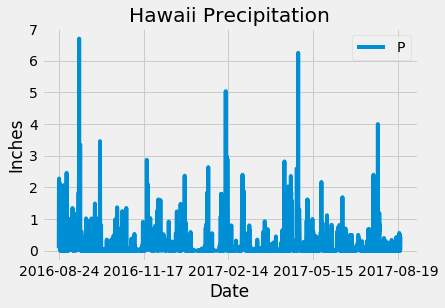

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_data.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend('Precipitation')
plt.title('Hawaii Precipitation')


In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.name)).all()

[(9)]

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#station_list=session.query(station.name).order_by(station.name.desc()).all()
#station_list
station_list = session.query(measurement.station, (func.count(measurement.station))).\
               group_by (measurement.station).\
               order_by(func.count(measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

stn_lowtemp = engine.execute('SELECT MIN(tobs) FROM measurement where station = "USC00519281"').fetchall()
stn_lowtemp

[(54.0,)]

In [27]:
# highest temperature recorded, and average temperature of the most active station?
stn_info = engine.execute('SELECT MAX(tobs),AVG(tobs) FROM measurement where station = "USC00519281"').fetchall()
stn_info

[(85.0, 71.66378066378067)]

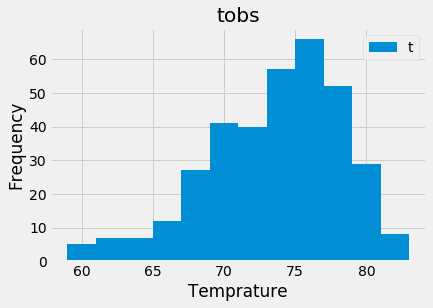

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

stn_query=session.query(measurement.station, measurement.tobs).\
    filter(measurement.station == "USC00519281").filter(measurement.date > previous_year).all()
    
temp_query = pd.DataFrame( stn_query, columns =["station","tobs"])

#temp_query.head()

temp_query.hist(bins=12)
plt.legend('tobs')
plt.xlabel('Temprature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#define dates from my previous year
start_date = '2011-02-28'
end_date = '2011-03-05'
temp_info=calc_temps(start_date,end_date)
print(temp_info)

[(61.0, 69.75510204081633, 75.0)]


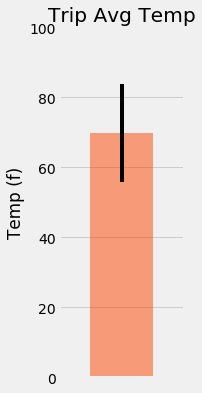

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_info_df = pd.DataFrame(temp_info,columns=['min temp','avg temp','max temp'])
avg_temp=temp_info_df['avg temp']
tminmax=temp_info_df.iloc[0][0]-temp_info_df.iloc[0][2]
avg_temp.plot(kind='bar',yerr=tminmax,figsize=(2,6),alpha=0.5,color='orangered')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (f)')
plt.grid(linestyle='-')
plt.xticks([])
plt.ylim(0,100)
plt.show()

In [57]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]
Prcp =  session.query(*sel).\
        filter(measurement.station == station.station).\
        group_by(measurement.station).\
        filter(func.strftime("%Y-%m-%d", measurement.date) >= start_date).\
        filter(func.strftime("%Y-%m-%d", measurement.date) <= end_date).\
        order_by(func.sum(measurement.prcp).desc()).all()
Prcp

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.23),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
